In [29]:
import pandas as pd
import numpy as np
import os
from joblib import dump, load
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, cross_validate
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from pprint import pprint
import random
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import cdist

dados = pd.read_csv ("Databases/PDACCTRL_samplesXfeatures_RAW.csv", sep=',')
dados

,Sample_ID,Grupo,MIMAT0000062_st,MIMAT0000063_st,MIMAT0000064_st,MIMAT0000065_st,MIMAT0000066_st,MIMAT0000067_st,MIMAT0000068_st,MIMAT0000069_st,...,MIMAT0031119_st,MIMAT0031120_st,MIMAT0031175_st,MIMAT0031176_st,MIMAT0031177_st,MIMAT0031178_st,MIMAT0031179_st,MIMAT0031180_st,MIMAT0031181_st,y
0,GSM2278612,PDAC,1.129491,5.508052,2.923399,1.751963,0.693354,0.750790,0.685247,5.234038,...,0.913821,0.660219,0.484359,0.954552,1.271430,1.405966,0.597030,0.935637,0.930258,1
1,GSM2278613,PDAC,1.727870,7.021726,4.075586,1.692451,0.748297,0.819648,1.228891,3.863134,...,0.572489,0.288395,0.911395,0.865855,1.191414,1.248563,0.880128,0.443996,0.461034,1
2,GSM2278614,PDAC,1.275866,5.847073,4.037849,1.675842,0.792464,0.854456,0.427473,5.030710,...,0.567179,0.585677,0.968250,0.416603,0.906936,0.515170,0.373492,1.029657,0.783717,1
3,GSM2278615,PDAC,1.231164,5.372768,3.634441,1.629729,0.835388,0.508545,0.633179,4.395977,...,0.606826,0.616086,0.910045,0.485816,0.481710,0.658906,0.486607,1.092210,0.877583,1
4,GSM2278616,PDAC,1.598425,5.448495,3.763625,1.970805,0.652223,0.442908,0.477028,4.051217,...,0.798609,0.780584,0.655019,0.591214,1.120507,1.493095,0.723840,0.936191,0.714010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,GSM2278758,Controle,1.072158,6.132864,4.303285,1.466693,1.066174,0.743631,0.542135,4.761716,...,0.565492,0.494150,0.605459,0.665845,1.061685,0.433729,0.351924,0.844252,0.267246,0
103,GSM2278759,Controle,1.688142,5.986205,3.848825,2.162682,0.984778,0.885241,0.934689,4.002943,...,0.829502,0.562959,1.029765,0.616121,0.528186,1.066021,0.886998,0.823196,0.621138,0
104,GSM2278760,Controle,1.507370,5.871728,3.430393,1.897419,0.627474,0.908978,0.458824,4.791717,...,1.177363,0.819254,0.368961,0.541980,1.179273,0.513666,0.789142,1.221342,0.959684,0
105,GSM2278761,Controle,0.588391,6.057384,4.142099,1.870668,1.081216,0.611892,0.771683,5.097688,...,0.604917,0.446808,0.563384,0.238049,0.932333,0.753658,0.141102,1.277319,0.443357,0


In [30]:
#normalizar
dados_num = dados.drop(columns=["Sample_ID", "Grupo", "y"])
dados_cat =dados[["Grupo"]]

#Instaciar o objeto normalizador
normalizador = preprocessing.MinMaxScaler()
#treinar o modelo normalizador
modelo_normalizador_num = normalizador.fit(dados_num)
#Salvando modelo normalizador para uso posterior
os.makedirs('models_Tree', exist_ok=True)
dump(modelo_normalizador_num, open("models_Tree/normalizador_TCC_Tree.model" , "wb" ))

#normalizar os atributos numericos
dados_num_normalizado = modelo_normalizador_num.transform(dados_num)
# Normalizar os dados Categoricos
dados_cat_normalizado = pd.get_dummies(dados_cat, dtype='int', dummy_na=True)
# Converter dados numéricos normalizados para DataFrame
dados_num_df = pd.DataFrame(dados_num_normalizado, columns=dados_num.columns)
# unir atributos num e cat que foram normalizados
dados_final = dados_num_df.join(dados_cat_normalizado)
dados_final

,MIMAT0000062_st,MIMAT0000063_st,MIMAT0000064_st,MIMAT0000065_st,MIMAT0000066_st,MIMAT0000067_st,MIMAT0000068_st,MIMAT0000069_st,MIMAT0000070_st,MIMAT0000071_st,...,MIMAT0031175_st,MIMAT0031176_st,MIMAT0031177_st,MIMAT0031178_st,MIMAT0031179_st,MIMAT0031180_st,MIMAT0031181_st,Grupo_Controle,Grupo_PDAC,Grupo_nan
0,0.364020,0.616390,0.295100,0.357728,0.346143,0.246612,0.281153,0.791741,0.567829,0.293147,...,0.318945,0.485705,0.572516,0.820679,0.450881,0.418451,0.829685,0,1,0
1,0.566594,0.930115,0.621546,0.339320,0.389451,0.274622,0.596963,0.371203,0.940650,0.244754,...,0.753015,0.430443,0.524971,0.710573,0.730846,0.132892,0.395607,0,1,0
2,0.413573,0.686656,0.610854,0.334182,0.424265,0.288782,0.131408,0.729368,0.610426,0.575846,...,0.810807,0.150539,0.355937,0.197553,0.229818,0.473060,0.694120,0,1,0
3,0.398440,0.588351,0.496557,0.319919,0.458100,0.148070,0.250906,0.534658,0.831239,0.250591,...,0.751642,0.193662,0.103271,0.298098,0.341681,0.509392,0.780955,0,1,0
4,0.522772,0.604046,0.533159,0.425419,0.313721,0.121369,0.160196,0.428900,1.000000,0.237128,...,0.492416,0.259330,0.482838,0.881627,0.576288,0.418772,0.629635,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.344610,0.745889,0.686059,0.269489,0.640015,0.243700,0.198017,0.646852,0.622801,0.311664,...,0.442040,0.305828,0.447887,0.140583,0.208489,0.365372,0.216334,1,0,0
103,0.553144,0.715492,0.557298,0.484770,0.575855,0.301305,0.426057,0.414091,0.457515,0.127880,...,0.873334,0.274848,0.130887,0.582882,0.737640,0.353141,0.543719,1,0,0
104,0.491946,0.691766,0.438745,0.402720,0.294213,0.310961,0.149621,0.656055,0.669959,0.330950,...,0.201646,0.228655,0.517757,0.196500,0.640867,0.584396,0.856907,1,0,0
105,0.180837,0.730245,0.640391,0.394445,0.651872,0.190110,0.331365,0.749914,0.581655,0.119255,...,0.399272,0.039293,0.371028,0.364379,0.000000,0.616909,0.379254,1,0,0


In [31]:
# remover a classe 'Grupo_nan' por ser insignificante
#dados_filtered = dados[~dados['Management'].isin(['missing', 'simultaneous appendectomy'])].copy()
dados_filtered = dados_final.drop(columns=['Grupo_nan'])

# Segmentar os dados em atributos e classes
dados_classes = dados_filtered[['Grupo_Controle', 'Grupo_PDAC']]
dados_atributos = dados_filtered.drop(columns=['Grupo_Controle', 'Grupo_PDAC'])

# Preprocessamento
# Tratar colunas categóricas
dados_cat = dados_atributos.select_dtypes(include=['object']).columns
dados_cat_normalizado = pd.get_dummies(dados_cat, dtype='int')

# Tratar colunas numéricas
dados_num = dados_atributos.select_dtypes(include=['number']).columns

# Preencher NaNs numéricos com a média da coluna
dados_num_preenchido = dados_atributos[dados_num].fillna(dados_atributos[dados_num].mean())

# Juntar numéricos preenchidos e categóricos dummificados
dados_processados = pd.concat([dados_num_preenchido, dados_cat_normalizado], axis=1)

# Criar uma coluna de classe unificada (1 = PDAC, 0 = Controle)
# Isso transforma o DataFrame de 2 colunas em uma única Series binária
dados_classes_bin = np.where(dados_classes['Grupo_PDAC'] == 1, 1, 0)

# Construir o objeto SMOTE e executar o fit_resample
resampler = SMOTE(random_state=42)
dados_atributos_b, dados_classes_b = resampler.fit_resample(dados_processados, dados_classes_bin)

# Verificar a frequência das classes balanceadas
print('#### FREQUÊNCIA DAS CLASSES APÓS O BALANCEAMENTO ####')
print(Counter(dados_classes_b))

#### FREQUÊNCIA DAS CLASSES APÓS O BALANCEAMENTO ####
Counter({1: 88, 0: 88})


In [32]:
# Dicionario para armazenar os dados balanceados das classes
dados_balanceados = {}

print("Início do balanceamento")

# Loop para balancear cada classe (3x)
for classe in dados_classes.columns:
    print(f"\nBalanceando para a classe: '{classe}'")

    # Criar vetor binario para a classe atual: 1 se for essa classe, 0 caso contrário
    y_bin = dados_classes[classe]

    # Instanciar SMOTE com random_state para reprodutibilidade
    smote = SMOTE(random_state=42)

    # Aplicar o balanceamento com SMOTE
    X_res, y_res = smote.fit_resample(dados_processados, y_bin)

    # Exibir a contagem das classes após balanceamento
    print("Distribuição das classes após balanceamento:")
    print(Counter(y_res))

    # Armazenar os dados balanceados para essa classe
    dados_balanceados[classe] = (X_res, y_res)

Início do balanceamento

Balanceando para a classe: 'Grupo_Controle'
Distribuição das classes após balanceamento:
Counter({0: 88, 1: 88})

Balanceando para a classe: 'Grupo_PDAC'
Distribuição das classes após balanceamento:
Counter({1: 88, 0: 88})


In [33]:
# Treinar cada classe balanceada
for classe, (X, y) in dados_balanceados.items():
    print(f"\nTreinando modelo para a classe: '{classe}'")

    # HOLD OUT (70-30)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    tree = DecisionTreeClassifier(random_state=42)

    # Determinar os HIPERPARAMETROS
    # Otimizar a arquitetura do metaestimador
    tree_grid = {'criterion': ['gini', 'entropy', 'log_loss'],'splitter': ['best', 'random'],'max_depth': [3, 6, 9, None],'max_features': ['sqrt', 'log2', None]}
    tree_hyperparameters = RandomizedSearchCV(tree,param_distributions=tree_grid,n_iter=10,cv=10,verbose=1,random_state=42,n_jobs=-1)
    tree_hyperparameters.fit(X_train, y_train)
    best_params = tree_hyperparameters.best_params_
    pprint(f"Melhores parametros para '{classe}': {best_params}")

    # Treinar o modelo com os melhores hiperparametros
    tree = DecisionTreeClassifier(**best_params, random_state=42)
    tree.fit(X, y)

    # Avaliar a acuracia do modelo com Cross Validation
    scores = cross_val_score(tree, X, y, cv=10, scoring='accuracy')
    print(f"Acurácia média para '{classe}': {scores.mean():.4f}")
    print(f"Acurácias individuais: {scores}")

    # Salvar modelo
    pasta_modelos = os.path.join(os.getcwd(), 'models_Tree')
    os.makedirs(pasta_modelos, exist_ok=True)

    nome_arquivo = f"modelo_{classe.replace(' ', '_')}.joblib"
    caminho_arquivo = os.path.join(pasta_modelos, nome_arquivo)
    dump(tree, caminho_arquivo)

    print(f"### Modelo salvo em: {caminho_arquivo}")




Treinando modelo para a classe: 'Grupo_Controle'
Fitting 10 folds for each of 10 candidates, totalling 100 fits
("Melhores parametros para 'Grupo_Controle': {'splitter': 'best', "
 "'max_features': None, 'max_depth': 3, 'criterion': 'gini'}")
Acurácia média para 'Grupo_Controle': 0.9830
Acurácias individuais: [0.94444444 1.         1.         1.         1.         0.94444444
 1.         0.94117647 1.         1.        ]
### Modelo salvo em: c:\Users\cassi\OneDrive\Documentos\1-Programas\TCC\models_Tree\modelo_Grupo_Controle.joblib

Treinando modelo para a classe: 'Grupo_PDAC'
Fitting 10 folds for each of 10 candidates, totalling 100 fits
("Melhores parametros para 'Grupo_PDAC': {'splitter': 'best', 'max_features': "
 "None, 'max_depth': 3, 'criterion': 'gini'}")
Acurácia média para 'Grupo_PDAC': 0.9830
Acurácias individuais: [0.94444444 1.         1.         1.         1.         0.94444444
 1.         0.94117647 1.         1.        ]
### Modelo salvo em: c:\Users\cassi\OneDrive\Docu

                miRNA  Importancia
1481  MIMAT0019745_st     0.768105
1738  MIMAT0021021_st     0.121768
645   MIMAT0004910_st     0.065717
633   MIMAT0004809_st     0.044410
1723  MIMAT0020541_st     0.000000
1717  MIMAT0019982_st     0.000000
1718  MIMAT0019983_st     0.000000
1719  MIMAT0019984_st     0.000000
1720  MIMAT0019985_st     0.000000
1721  MIMAT0020299_st     0.000000
1722  MIMAT0020300_st     0.000000
1724  MIMAT0020600_st     0.000000
1715  MIMAT0019980_st     0.000000
1725  MIMAT0020601_st     0.000000
1726  MIMAT0020602_st     0.000000
1727  MIMAT0020603_st     0.000000
1728  MIMAT0020924_st     0.000000
1729  MIMAT0020925_st     0.000000
1730  MIMAT0020956_st     0.000000
1731  MIMAT0020957_st     0.000000


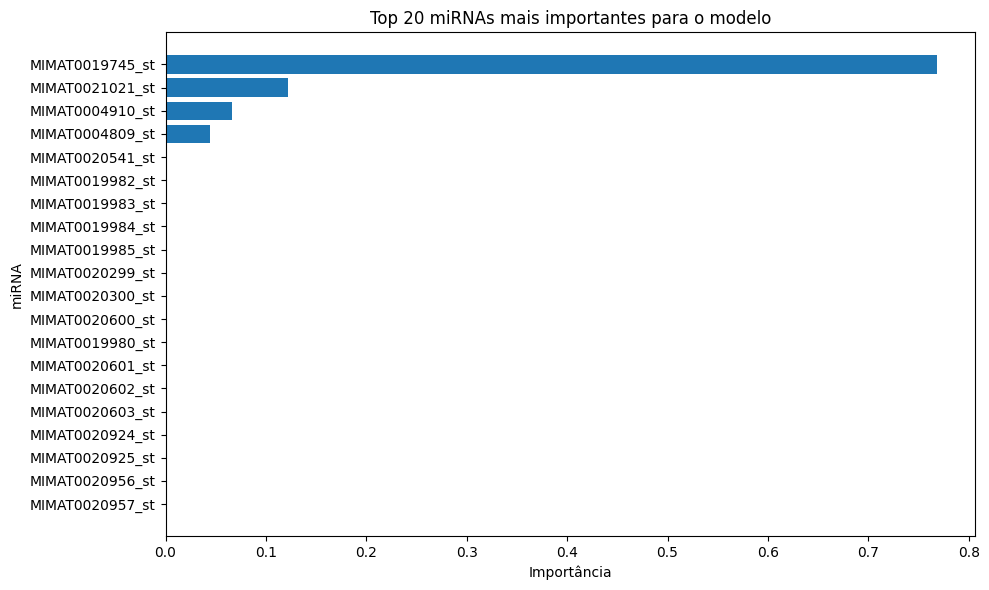

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Obter importâncias das features
importancias = tree.feature_importances_
colunas = dados_processados.columns

# Criar DataFrame de importância
importancia_df = pd.DataFrame({
    'miRNA': colunas,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Exibir top 20 mais importantes
print(importancia_df.head(20))

# Plotar gráfico
plt.figure(figsize=(10,6))
plt.barh(importancia_df['miRNA'].head(20)[::-1], importancia_df['Importancia'].head(20)[::-1])
plt.xlabel('Importância')
plt.ylabel('miRNA')
plt.title('Top 20 miRNAs mais importantes para o modelo')
plt.tight_layout()
plt.show()

#Horrivel estranho e pessimo so listar 4 MIRNAs importantes

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from joblib import load
from collections import Counter

# --- CARREGAR NORMALIZADOR ---
normalizador = load(open("models_Tree/normalizador_TCC_Tree.model", "rb"))

# --- CARREGAR MODELOS ---
caminho_modelos = os.path.join(os.getcwd(), 'models_Tree')
nomes_classes = ['Grupo_Controle', 'Grupo_PDAC']

modelos = {}
for classe in nomes_classes:
    nome_arquivo = f"modelo_{classe.replace(' ', '_')}.joblib"
    caminho_arquivo = os.path.join(caminho_modelos, nome_arquivo)
    modelos[classe] = load(caminho_arquivo)

print("Modelos carregados com sucesso!\n")


# Gerar amostras random
num_mirnas = 2579

# gerar valores aleatórios entre -5 e 5 (ajuste conforme sua base)
mirna_valores = [round(random.uniform(-5, 5), 4) for _ in range(num_mirnas)]

# criar nomes de colunas (ex: miR_1, miR_2, ..., miR_2579)
colunas_mirna = [f"miR_{i+1}" for i in range(num_mirnas)]

# criar DataFrame
paciente_mirna_df = pd.DataFrame([mirna_valores], columns=colunas_mirna)


# --- NORMALIZAR AMOSTRA ---
# Garantir que o paciente tenha as mesmas colunas que o normalizador esperava
colunas_esperadas = normalizador.feature_names_in_

# Criar cópia da amostra e ajustar colunas
paciente_mirna_df_alinhado = paciente_mirna_df.reindex(columns=colunas_esperadas, fill_value=0)

# Agora normalizar
paciente_mirna_norm = normalizador.transform(paciente_mirna_df_alinhado)
paciente_mirna_norm_df = pd.DataFrame(paciente_mirna_norm, columns=colunas_esperadas)

# --- AJUSTAR COLUNAS ---
# usar colunas esperadas de um dos modelos (garante compatibilidade)
colunas_esperadas = modelos['Grupo_PDAC'].feature_names_in_

# reindexar para garantir mesma ordem e preencher faltantes com 0
paciente_final_df = paciente_mirna_norm_df.reindex(columns=colunas_esperadas).fillna(0)

# --- FUNCAO DE INFERENCIA ---
def fazer_inferencia(paciente_df):
    resultados = {}
    print("\nRealizando inferência...\n")

    paciente_array = paciente_df.values  # converter para ndarray

    for classe, modelo in modelos.items():
        proba = modelo.predict_proba(paciente_array)[0][1]
        resultados[classe] = proba
        print(f"Probabilidade para '{classe}': {proba:.4f}")

    classe_predita = max(resultados, key=resultados.get)
    print(f"\nClasse predita: {classe_predita} (Probabilidade: {resultados[classe_predita]:.4f})")

    return classe_predita, resultados

# --- EXECUTAR INFERENCIA ---
classe_predita, probabilidades = fazer_inferencia(paciente_final_df)

# --- MOSTRAR RESULTADOS ---
df_prob = pd.DataFrame.from_dict(probabilidades, orient='index', columns=['Probabilidade'])
df_prob = df_prob.sort_values(by='Probabilidade', ascending=False)
df_prob['Probabilidade (%)'] = df_prob['Probabilidade'] * 100

print("\nProbabilidades ordenadas:")
print(df_prob[['Probabilidade (%)']])

Modelos carregados com sucesso!


Realizando inferência...

Probabilidade para 'Grupo_Controle': 1.0000
Probabilidade para 'Grupo_PDAC': 0.0000

Classe predita: Grupo_Controle (Probabilidade: 1.0000)

Probabilidades ordenadas:
                Probabilidade (%)
Grupo_Controle              100.0
Grupo_PDAC                    0.0


c:\Users\cassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\cassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
